<a href="https://colab.research.google.com/github/Hani1-2/DeepLearningAssignmnt/blob/master/SpeechRecognition_forSurahFatiha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Pre-Processing Dataset
Here we took 7-Ayah of surah Fatiha, consist of 8 folders, each containing 28 recordings of recitation of different recitors.

In [1]:
import librosa
import os
import json

In [2]:
DATASET_PATH = "001/002"
JSON_PATH = "merged_data.json"
SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio

In [3]:
# dictionary where we'll store mapping, labels, MFCCs and filenames
data = {
    "mapping": [],
    "labels": [],
    "MFCCs": [],
    "files": []
}

In [ ]:
_mapping = [
    "Bis'mi", #1
    "Al-lahi", #2
    "Al-rahmaani", #3
    "Al-raheemi", #4
    "Alhamdu", #5
    "lillaahi", #6
    "Rabbil", #7
    "aalameen", #8
    "Ar-Rahmaan", #9
    "Ar-Raheem", #10
    "Maaliki", #11
    "Yumid", #12
    "Diin", #13
    "Iyyaka", #14
    "Na'abudu", #15
    "Iyyaka", #16
    "Nasta'een", #17
    "Ihdinas", #18
    "Siraatal", #19
    "Mustaqeem", #20
    "Siraatal", #21
    "Ladheena", #22
    "An'amta", #23
    "Alaihim", #24
    "Ghayril", #25
    "Maghdubi", #26
    "Alaihim", #27
    "Wala al-dalina", #28
]

def preprocess_dataset(data, dataset_path, json_path, num_mfcc=40, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping
            label = dirpath[-2:]
            label = int(label)
            print("label",label)
            data["mapping"].append(_mapping[label-1])

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)

                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:

                    # ensure consistency of the length of the signal
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                 hop_length=hop_length)

                    # store data for analysed track
                    data["MFCCs"].append(MFCCs.T.tolist())
                    # data["labels"].append(i-1)
                    data["labels"].append(label)
                    data["files"].append(file_path)
                    print("{}: {}".format(file_path, i-1))

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

# JSON_PATH = "data7.json"
# if __name__ == "__main__":
#     preprocess_dataset(data, DATASET_PATH, JSON_PATH)

'''Combine json files'''
merged_data = {
    "mapping": [],
    "labels": [],
    "MFCCs": [],
    }

# Loop through each JSON file
for filename in ["data.json", "data1.json", "data2.json","data3.json","data4.json","data5.json","data6.json","data7.json"]:
    with open(filename) as file:
        data = json.load(file)
        # Merge the data into the dictionary
        merged_data["mapping"] += data["mapping"]
        merged_data["labels"]+= data["labels"]
        merged_data["MFCCs"] += data["MFCCs"]

# Write the merged data to a new file
with open("merged_data.json", "w") as file:
    json.dump(merged_data, file)

##Loading the Data

In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

DATA_PATH = "data_a12.json"
SAVED_MODEL_PATH = "model.h5"
EPOCHS = 100 # iterations
BATCH_SIZE = 32 # no of samples in one iteration
PATIENCE = 5
LEARNING_RATE = 0.0001


def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [2]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print('X train dataset', X_train)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [3]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    since 44 are the segments and 13 are the co-efficient of MFCC we extracted and the depth is set as 1 (like grayscale)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    # Sequential model consist of bunch of layers one leads to another and so on
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    # down sampling the ouput layers
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    # dropout prevent overfitting
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(27, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model


In [4]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history


In [5]:

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

Training sets loaded!
X train dataset [[[-1.81904343e+02  1.63071808e+02  1.53573122e+01 ...  2.37216353e-01
    1.05100689e+01  1.78078499e+01]
  [-2.02787308e+02  1.96381241e+02  1.28288326e+01 ...  3.05340481e+00
    1.41372414e+01  2.19204063e+01]
  [-2.35148392e+02  2.18943726e+02  9.48603439e+00 ...  6.83639526e+00
    1.71930904e+01  2.37729950e+01]
  ...
  [-2.27421829e+02  1.60124664e+02 -2.19633865e+01 ...  2.25339050e+01
    1.69014530e+01  2.03290901e+01]
  [-1.45937622e+02  1.25190384e+02 -1.81396961e+00 ...  1.79532490e+01
    1.41880264e+01  1.41362276e+01]
  [-1.10720261e+02  1.15470177e+02  9.40768814e+00 ...  1.24782677e+01
    6.82256079e+00  8.74225903e+00]]

 [[-1.74260941e+02  1.45080292e+02  4.83571172e-01 ... -1.12236404e+01
   -1.06122217e+01 -3.95807576e+00]
  [-1.19956116e+02  1.46377655e+02 -2.13994102e+01 ... -3.80618000e+00
   -1.02587051e+01 -3.59400034e+00]
  [-9.00876389e+01  1.43591431e+02 -4.24596939e+01 ... -4.75371933e+00
   -1.04950905e+01 -3.09217

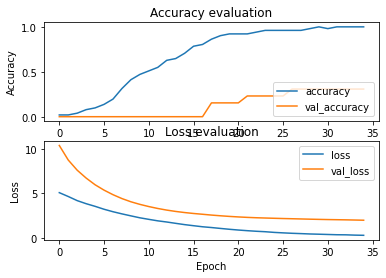

1/1 [==============================] - 0s 95ms/step - loss: 1.6737 - accuracy: 0.5882
None


In [6]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
    print('X_train',X_train[0])
    print('y_train',y_train)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape=input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    # print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    m = model.save(SAVED_MODEL_PATH)
    print(m)


if __name__ == "__main__":
    main()



In [8]:
import librosa
import tensorflow as tf
import numpy as np

SAVED_MODEL_PATH = "model.h5"
SAMPLES_TO_CONSIDER = 22050

class _Keyword_Spotting_Service:
    """Singleton class for keyword spotting inference with trained models.

    :param model: Trained model
    """

    model = None
    _mapping = {
    1:"Bis'mi",
    2:"Al-lahi",
    3:"Al-rahmaani",
    4:"Al-raheemi",
    5:"Alhamdu",
    6:"lillaahi",
    7:"Rabbil",
    8:"aalameen",
    9:"Ar-Rahmaan",
    10:"Ar-Raheem",
    11:"Maaliki",
    12:"Yumid",
    13:"Diin",
    14:"Iyyaka",
    15:"Na'abudu",
    16:"Iyyaka",
    17:"Nasta'een",
    18:"Ihdinas",
    19:"Siraatal",
    20:"Mustaqeem",
    21:"Siraatal",
    22:"Ladheena",
    23:"An'amta",
    24:"Alaihim",
    25:"Ghayril",
    26:"Maghdubi",
    27:"Alaihim",
    28:"Wala al-dalina"
}

    _instance = None


    def predict(self, file_path):
        """

        :param file_path (str): Path to audio file to predict
        :return predicted_keyword (str): Keyword predicted by the model
        """

        # extract MFCC
        MFCCs = self.preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = self.model.predict(MFCCs) # a 2d array [[]]
        predicted_index = np.argmax(predictions)
        print('predicted index',predicted_index)
        # index return the index which has highest score
        predicted_keyword = self._mapping[predicted_index]
        # print('prediction',predicted_index,predicted_keyword)
        return predicted_keyword


    def preprocess(self, file_path, num_mfcc=40, n_fft=2048, hop_length=512):
        """Extract MFCCs from audio file.

        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples

        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """

        # load audio file
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= SAMPLES_TO_CONSIDER:
            # ensure consistency of the length of the signal (if the len of the array greater than trained array, we'll limit to it as per the trained array length)
            signal = signal[:SAMPLES_TO_CONSIDER]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
            return MFCCs.T
        else:
            signal = signal[:SAMPLES_TO_CONSIDER]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
            return MFCCs.T


def Keyword_Spotting_Service():
    """Factory function for Keyword_Spotting_Service class.

    :return _Keyword_Spotting_Service._instance (_Keyword_Spotting_Service):
    """

    # ensure an instance is created only the first time the factory function is called
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance


In [10]:
if __name__ == "__main__":

    # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()
    kss1 = Keyword_Spotting_Service()

    # check that different instances of the keyword spotting service point back to the same object (singleton)
    assert kss is kss1

    # make a prediction
    keyword = kss.predict("012.wav")
    print(keyword)

1/1 [==============================] - 0s 223ms/step
predicted index 8
aalameen
